In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def calibrate_camera_images(chessboard_files, shape):
     # calibrate camera here
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane
    for chessboard_file in chessboard_files:
        img = cv2.imread(chessboard_file)
        # convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find corners
        ret, corners = cv2.findChessboardCorners(gray, shape, None)
        # draw corners
        if ret:
            cv2.drawChessboardCorners(img, shape, corners, ret)
            plt.figure()
            plt.imshow(img)
            # generate image coordinates using mgrid
            objp = np.zeros((shape[0]*shape[1],3),np.float32)
            # fix x,y coordinate
            objp[:,:2] = np.mgrid[0:shape[0],0:shape[1]].T.reshape(-1,2)
            objpoints.append(objp)
            imgpoints.append(corners)
    # now calibrate camera
    ret, mtx, dist, rvect, tvects = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return ret, mtx, dist, rvect, tvects    

## Calibrate Camera

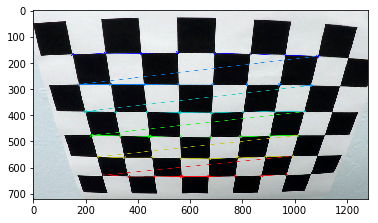

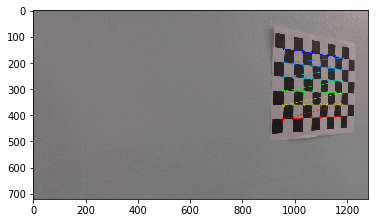

In [6]:
import glob
image_files = glob.glob('camera_cal/*.jpg')
ret, mtx, dist, rvect, tvects = calibrate_camera_images(image_files, (8,6))

## Undistort image

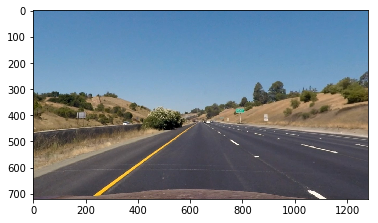

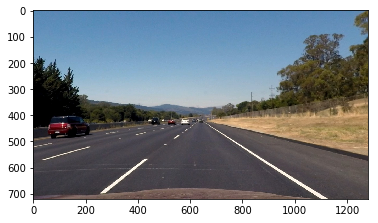

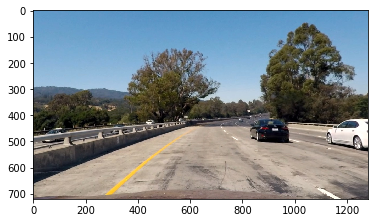

In [7]:
# undistort image here 
undistort_images = []
image_files = [
                'test_images/straight_lines1.jpg',
                'test_images/straight_lines2.jpg',
                'test_images/test1.jpg'
              ]
for image in image_files:
    img = cv2.imread(image)
    plt.figure()
    undistort_images.append(cv2.undistort(img, mtx, dist, None, mtx))
    plt.imshow(cv2.cvtColor(undistort_images[-1], cv2.COLOR_BGR2RGB))

## Color and Gradient Threshold

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        grad_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    else:
        grad_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    scaled_img = np.uint8(grad_img / np.max(grad_img) * 255.0)
    final_img = np.zeros_like(scaled_img)
    final_img[(scaled_img > thresh[0]) & (scaled_img < thresh[1])] = 1
    return final_img

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binaryx_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    binaryy_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    binary_img = np.sqrt(binaryx_img**2 + binaryy_img**2)
    scaled_img = np.uint8(binary_img / np.max(binary_img) * 255.0)
    final_img = np.zeros_like(scaled_img)
    final_img[(scaled_img > mag_thresh[0]) & (scaled_img < mag_thresh[1])] = 1
    return final_img

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binaryx_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    binaryy_img = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    binary_img = np.arctan2(binaryy_img, binaryx_img)
    final_img = np.zeros_like(binary_img)
    final_img[(binary_img > thresh[0]) & (binary_img < thresh[1])] = 1
    return final_img



Absolute Image Threshold


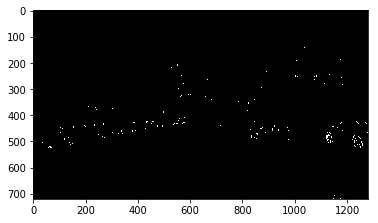

In [9]:
abs_image = abs_sobel_thresh(undistort_images[-1], thresh=(90,255))
print ("Absolute Image Threshold")
plt.figure()
plt.imshow(abs_image, cmap='gray')

Gradient Magnitude Image Threshold


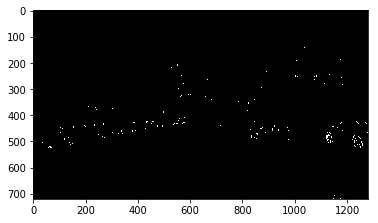

In [10]:
mag_grad_image = mag_thresh(undistort_images[-1], mag_thresh=(110,255))
print ("Gradient Magnitude Image Threshold")
plt.figure()
plt.imshow(abs_image, cmap='gray')

Gradient Direction Image Threshold


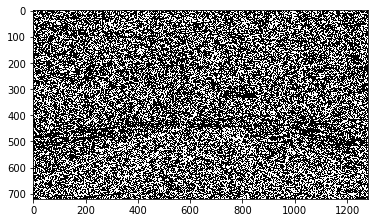

In [11]:
dir_image = dir_threshold(undistort_images[-1], sobel_kernel=15, thresh=(0.7, 1.3))
print ("Gradient Direction Image Threshold")
plt.figure()
plt.imshow(dir_image, cmap='gray')

In [12]:
# HLS channel thresholding 
def s_channel_thresholding(img, threshold=(95,255)):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_chan = hsv_img[:,:,2]
    print(s_chan.shape)
    binary_img = np.zeros_like(s_chan)
    binary_img [(s_chan > threshold[0]) & (s_chan < threshold[1])] = 1
    print (s_chan > threshold[0])
    return binary_img
    

(720, 1280)
[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


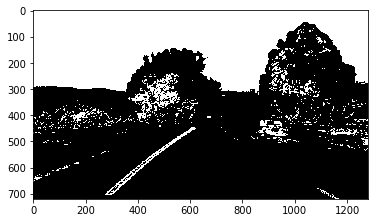

In [13]:
plt.figure()
s_image= s_channel_thresholding(undistort_images[-1], threshold=(95,255))
#print(s_image.shape)
plt.imshow(s_image, cmap='gray')

In [14]:
# COMBINE THRESHOLDS
img = undistort_images[-1]
shape = img.shape[:2]
combine_mask_img = np.zeros(shape)
combine_mask_img[(s_image > 0) | ((mag_grad_image >0) & (dir_image > 0)) | (abs_image > 0)] = 1
plt.figure()


In [15]:
def threshold_image(img):
    abs_image = abs_sobel_thresh(img, thresh=(90,255))
    mag_grad_image = mag_thresh(img, mag_thresh=(110,255))
    dir_image = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    s_image = s_channel_thresholding(undistort_images[-1], threshold=(95,255))
    shape = img.shape[:2]
    combine_mask_img = np.zeros(shape)
    combine_mask_img[(s_image > 0) | ((mag_grad_image >0) & (dir_image > 0)) | (abs_image > 0)] = 1
    return combine_mask_img
    

## Warp the image

[[  590.           443.52941895]
 [  670.           443.52941895]
 [ 1280.           690.        ]
 [  170.           690.        ]]


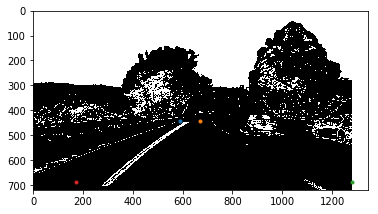

In [16]:
src = np.float32([
        [combine_mask_img.shape[1]/2 - 50, combine_mask_img.shape[0]/1.7 + 20], # tl
        [combine_mask_img.shape[1]/2 + 30, combine_mask_img.shape[0]/1.7 + 20], # tr
        [combine_mask_img.shape[1], combine_mask_img.shape[0] -30], # br
        [170, combine_mask_img.shape[0] - 30] # bl
    ])
print (src)
h, w = combine_mask_img.shape

plt.imshow(combine_mask_img, cmap='gray')
plt.plot(src[0][0], src[0][1], '.')
plt.plot(src[1][0], src[1][1], '.')
plt.plot(src[2][0], src[2][1], '.')
plt.plot(src[3][0], src[3][1], '.')

In [17]:
def warp_image(undistort_image, mtx, dist):
    # transform to gray
    #gray = cv2.cvtColor(undistort_image, cv2.COLOR_BGR2GRAY)
    print(undistort_image.shape[1], undistort_image.shape[0])
    width, height = undistort_image.shape[1], undistort_image.shape[0]
    src = np.float32([
        [undistort_image.shape[1]/2 - 120, undistort_image.shape[0]/1.8 + 50], # tl
        [undistort_image.shape[1]/2 + 120, undistort_image.shape[0]/1.8 + 50], # tr
        [undistort_image.shape[1], undistort_image.shape[0] - 20], # br
        [0, undistort_image.shape[0] - 20] # bl
    ])
    tl,tr,br,bl = src
    print (src)
    
    width = int(np.sqrt((bl[0] - br[0])**2 + (bl[1] - br[1])**2))
    height = int(max(np.sqrt((tl[0] - bl[0])**2 + (tl[1] - bl[1])**2), np.sqrt((tr[0] - br[0])**2 + (tr[1] - br[1])**2)))
    print ("height ", height)
    print ("width ", width)
    dst = np.float32([
        [0,0], # tl
        [width - 1, 0], # tr
        [width - 1, height - 1], # br
        [0, height -1] # bl
    ], dtype='float32')
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistort_image, M, (width, height), flags=cv2.INTER_LINEAR)
    return warped, M, (tl,tr,br,bl)

(720, 1280)
[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]
(720, 1280)
[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]
1280 720
[[  520.   450.]
 [  760.   450.]
 [ 1280.   700.]
 [    0.   700.]]
height  576
width  1280
1280 720
[[  520.   450.]
 [  760.   450.]
 [ 1280.   700.]
 [    0.   700.]]
height  576
width  1280


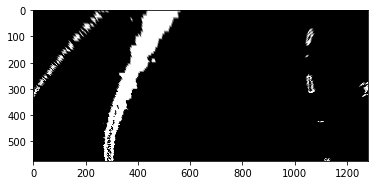

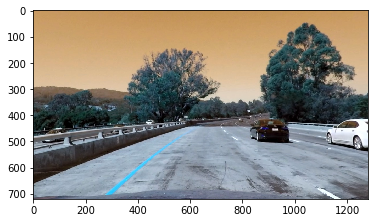

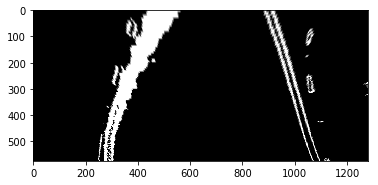

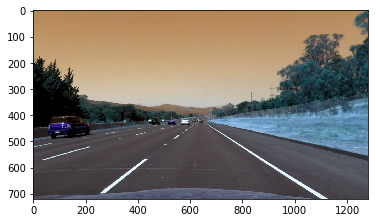

In [18]:
warped = threshold_image(undistort_images[-1])
warped2 = threshold_image(undistort_images[-2])
warped, M, src = warp_image(warped, mtx, dist)
warped2, M2, src2 = warp_image(warped2, mtx, dist)
plt.figure()
plt.imshow(warped, cmap='gray')
plt.figure()
plt.imshow(undistort_images[-1])
plt.figure()
plt.imshow(warped2,cmap='gray')
plt.figure()
plt.imshow(undistort_images[-2])

## Finding lanes

In [19]:
def find_lanes(warped_image, margin=100, minpix=50, debug=False):
    """
        
        margin: where to search for pixel
        minpix: number of nonzero pix that trigger re-center
    """
    # use histogram to find peaks
    # sum pixels along colums
    histogram = np.sum(warped_image, axis=0)
    # empty output image for visualizing
    output_img = np.dstack((warped_image, warped_image, warped_image)) * 255
    # find base of starting x positions for left and right lane
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # find number of windows
    nwindows = 10
    window_height = np.int(warped_image.shape[0] // nwindows)
    # get nonzero tuple
    print(warped_image.shape)
    nonzero_y, nonzero_x = warped_image.nonzero()
    l_x = leftx_base
    r_x = rightx_base
    left_lane_indices = []
    right_lane_indices = []
    
    for iw in range(nwindows):
        w_y_low = warped_image.shape[0] - (iw + 1)*window_height
        w_y_high = w_y_low + window_height
        # left lane
        w_x_left_low = l_x - margin
        w_x_left_high = l_x + margin
        # right lane
        w_x_right_low = r_x - margin
        w_x_right_high = r_x + margin
        # draw image for visualizing
        
#         print("Draw rect x,y:" ,w_x_left_low, w_y_low, w_x_left_high, w_y_high)
        if debug:
            cv2.rectangle(output_img,(w_x_left_low, w_y_low),(w_x_left_high, w_y_high),(0,255,0), 4) 
            cv2.rectangle(output_img,(w_x_right_low, w_y_low),(w_x_right_high, w_y_high),(0,255,0), 4) 
#         plt.figure()
#         plt.imshow(output_img)
        # find good left land indices
        good_left_lane_indices = (nonzero_y >= w_y_low) & (nonzero_y < w_y_high) \
                    & (nonzero_x >= w_x_left_low) & (nonzero_x < w_x_left_high)
        
        good_right_lane_indices = (nonzero_y >= w_y_low) & (nonzero_y < w_y_high) \
                    & (nonzero_x >= w_x_right_low) & (nonzero_x < w_x_right_high)
        
        # remove all False value
        good_left_lane_indices = good_left_lane_indices.nonzero()[0]
        good_right_lane_indices = good_right_lane_indices.nonzero()[0]
    
        # append to full list
        left_lane_indices.append(good_left_lane_indices)
        right_lane_indices.append(good_right_lane_indices)
        
        # change the center if number of pix is at threshold
        #print ("len ",len(good_left_lane_indices), len(good_right_lane_indices))
        if len(good_left_lane_indices) > minpix:
            l_x = np.int(np.mean(nonzero_x[good_left_lane_indices]))
        if len(good_right_lane_indices) > minpix:
            r_x = np.int(np.mean(nonzero_x[good_right_lane_indices]))
        
   
    # now we have an array list of all good indices
    all_good_left_lanes = np.concatenate(left_lane_indices)    
    all_good_right_lanes = np.concatenate(right_lane_indices)    
    
    # extract x,y coordinates for each lane so we can fit a polynomial through them
    leftx = nonzero_x[all_good_left_lanes]
    lefty = nonzero_y[all_good_left_lanes]
    rightx = nonzero_x[all_good_right_lanes]
    righty = nonzero_y[all_good_right_lanes]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # FOR PLOTTING ONLY 
    if debug:
        ploty = np.linspace(0, warped_image.shape[0] - 1, warped_image.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        output_img[nonzero_y[all_good_left_lanes], nonzero_x[all_good_left_lanes]] = [255, 0, 0]
        output_img[nonzero_y[all_good_right_lanes], nonzero_x[all_good_right_lanes]] = [0, 0, 255]
        plt.figure(figsize=(10,10))
        # hacky way to write cv2 image to file 
        cv2.imwrite('test.jpg', output_img)
        test = plt.imread("test.jpg")
        plt.imshow(test)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='green')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit
    

(576, 1280)
(576, 1280, 3)


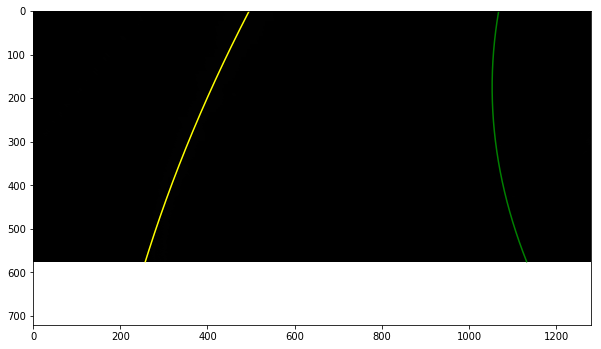

In [25]:
left_fit, right_fit = find_lanes(warped)
plot_x_y(warped, left_fit, right_fit)

In [26]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

In [31]:
def search_around_poly(binary_warped, left_fit, right_fit, margin=100, thershold=0.8):
    nonzero = binary_warped.nonzero()
    nonzero_y = np.array(nonzero[0])
    nonzero_x = np.array(nonzero[1])
    
    # search around the current left fit and right fit 
    left_lane_x_margin_left = (left_fit[0] * (nonzero_y**2) + left_fit[1] * nonzero_y + left_fit[2] - margin)
    left_lane_x_margin_right = (left_fit[0] * (nonzero_y**2) + left_fit[1] * nonzero_y + left_fit[2] + margin)
    left_lane_ids = (nonzero_x >= left_lane_x_margin_left) & (nonzero_x < left_lane_x_margin_right)
    
    right_lane_x_margin_left = (right_fit[0] * (nonzero_y**2) + right_fit[1] * nonzero_y + right_fit[2] - margin)
    right_lane_x_margin_right = (right_fit[0] * (nonzero_y**2) + right_fit[1] * nonzero_y + right_fit[2] + margin)
    right_lane_ids = (nonzero_x >= right_lane_x_margin_left) & (nonzero_x < right_lane_x_margin_right)
    
    # TODO:
    # if number of pixels ids is smaller than some threshold
    # return none so we will use sliding windows to rediscover the windows
    if (len(left_lane_ids) + len(right_lane_ids)) / np.float(len(nonzero_x)) < threshold:
        return None, None, None, None, None
    
    
    leftx = nonzero_x[left_lane_ids]
    lefty = nonzero_y[left_lane_ids]
    rightx = nonzero_x[right_lane_ids]
    righty = nonzero_y[right_lane_ids]
    
    # now we have the values
    return fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

In [32]:
def plot_x_y(warped_image, left_fit, right_fit):
    # FOR PLOTTING ONLY 
    output_img = np.dstack((warped_image, warped_image, warped_image))
    print(output_img.shape)
    ploty = np.linspace(0, warped_image.shape[0] - 1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    plt.figure(figsize=(10,10))
    plt.imshow(np.uint8(output_img))
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='green')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

(576, 1280, 3)


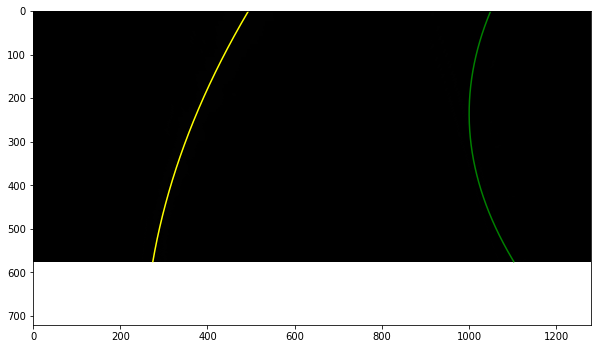

In [33]:
left_fit2, right_fit2, _, _, _ = search_around_poly(warped2, left_fit, right_fit) 
plot_x_y(warped2, left_fit2, right_fit2)